# Infer UNETCNX

In [ ]:
!nvidia-smi

Wed Jul 20 08:04:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Setup environment

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/CardiacSeg

# !pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio===0.9.0 -f https://download.pytorch.org/whl/torch_stable.html
!pip install monailabel-weekly
!pip install monai
!pip uninstall opencv-contrib-python -y
!pip install opencv-python==4.1.2.30 opencv-contrib-python==4.1.2.30

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/CardiacSeg
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Found existing installation: opencv-contrib-python 4.1.2.30
Uninstalling opencv-contrib-python-4.1.2.30:
  Successfully uninstalled opencv-contrib-python-4.1.2.30
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached opencv_contrib_python-4.1.2.30-cp37-cp37m-manylinux1_x86_64.whl (34.3 MB)


In [ ]:
import os
from pathlib import PurePath
from functools import partial
from pprint import pprint
from typing import Optional, Callable, List, Any, Sequence


import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from monai.utils import first
from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AddChannel,
    SaveImage,
    AsDiscrete,
    AsDiscreted,
    ToNumpyd,
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    ToTensord,
    LabelFilterd,
    MapLabelValued,
    SaveImaged,
    ToDeviced,
    EnsureTyped,
    SqueezeDimd
)


from monai.metrics import DiceMetric, HausdorffDistanceMetric
from monai.networks.blocks import UnetrBasicBlock, UnetrUpBlock, UnetOutBlock

from monai.data import (
    NibabelWriter,
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
    TestTimeAugmentation
)

from monai.transforms.utils import allow_missing_keys_mode
from monailabel.transform.post import BoundingBoxd, Restored

import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

import torchvision
from torchvision.models.convnext import ConvNeXt, CNBlockConfig, CNBlock
from torchvision.ops.stochastic_depth import StochasticDepth
from torchsummary import summary

import pandas as pd

## Setup config

In [ ]:
is_infer_SegTHOR_dataset = True

class Config:
  model_repo = 'UNETCNX/SegTHOR'
  model_name = 'k7_f48_p4_d9'
  use_pretrained_model = True
  root_dir = './'
  infer_dir = os.path.join(root_dir, model_repo, 'infers', model_name)
  model_dir = os.path.join(root_dir, model_repo, 'models', model_name)
  pretrained_model_pth = os.path.join(model_dir, 'dc_9762_best_metric_model.pth')

class SegTHORConfig(Config):
  use_crop_foreground = True
  pid = 'Patient_40'
  infer_dir = os.path.join(Config.infer_dir, f'SegTHOR/{pid}')
  img_pth = os.path.join(Config.root_dir, f'dataset/SegTHOR/train/{pid}/{pid}.nii.gz')
  lbl_pth = os.path.join(Config.root_dir, f'dataset/SegTHOR/train/{pid}/GT.nii.gz')
  infer_img_pth = os.path.join(infer_dir, f'infer_{pid}.nii.gz')
  transform_img_pth = os.path.join(infer_dir, f'trans_{pid}.nii.gz')
  transform_lbl_pth = os.path.join(infer_dir, 'trans_GT.nii.gz')

class CHGHConfig(Config):
  use_crop_foreground = False
  infer_dir = os.path.join(Config.infer_dir, 'chgh/corcta')
  img_pth = os.path.join(Config.root_dir, 'dataset/corcta/corcta.nii.gz')
  lbl_pth = None
  infer_img_pth = os.path.join(infer_dir, 'corcta.nii.gz')


if is_infer_SegTHOR_dataset:
  config = SegTHORConfig
else:
  config = CHGHConfig

os.makedirs(config.infer_dir, exist_ok=True)

data_dict = {
  'image': config.img_pth,
  'label': config.lbl_pth,
}

## Setup pre transforms and post transforms


In [ ]:
if config.__name__ == 'SegTHORConfig':
    pre_transforms = Compose([
        LoadImaged(keys=["image", "label"]),
        LabelFilterd(keys=["label"], applied_labels=[2]),
        MapLabelValued(keys=["label"], orig_labels=[0,2], target_labels=[0,1]),
        AddChanneld(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True
        ),
        CropForegroundd(keys=['image','label'], source_key='label',margin=40),
        AddChanneld(keys=["image", "label"]),
        ToTensord(keys=["image", "label"]),
    ])
else:
    pre_transforms = Compose([
        LoadImaged(keys=["image"]),
        AddChanneld(keys=["image"]),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(
            keys=["image"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear"),
        ),
        ScaleIntensityRanged(
            keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True
        ),
        AddChanneld(keys=["image"]),
        ToTensord(keys=["image"]),
    ])

post_transforms = Compose([
    Orientationd(keys=["pred"], axcodes="LPS"),
    ToNumpyd(keys="pred"),
    Restored(keys=["pred"], ref_image="image"),
    BoundingBoxd(keys="pred", result="result", bbox="bbox")
])

## Check data shape and visualize

img path: ./dataset/SegTHOR/train/Patient_40/Patient_40.nii.gz
original img shape: (512, 512, 203)
transformed img shape: torch.Size([1, 1, 170, 153, 130])


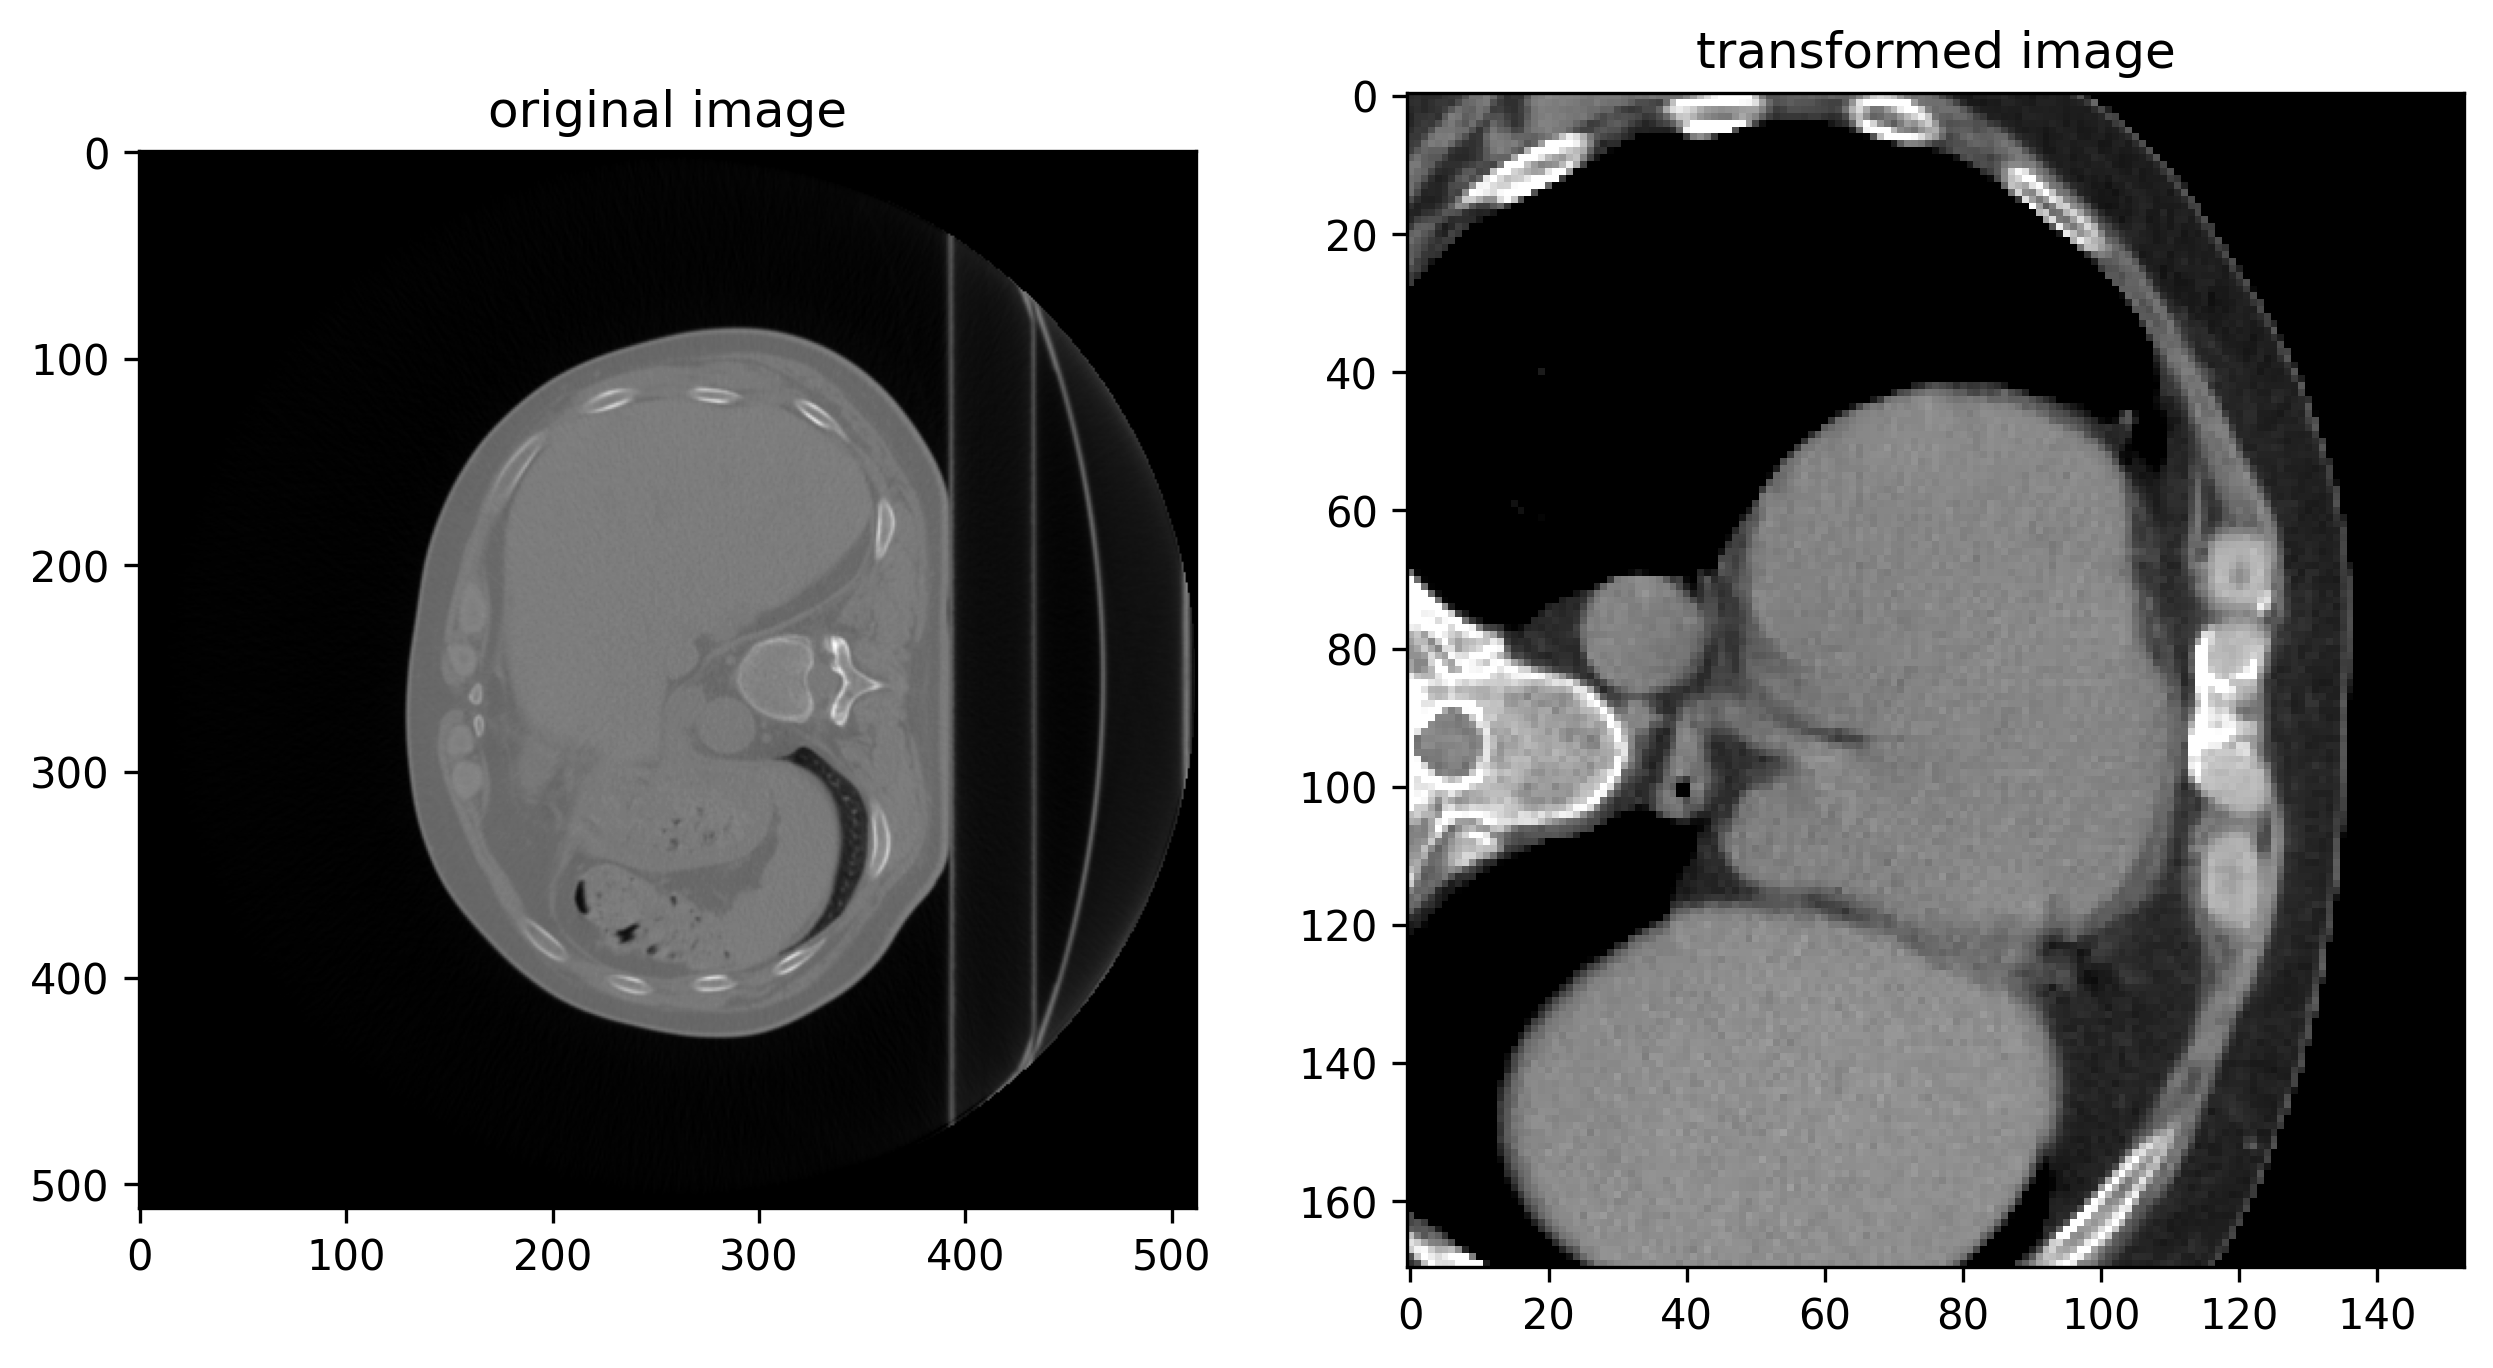

In [ ]:
src_img = LoadImaged(keys=["image"])(data_dict)['image']
trfm_img = pre_transforms(data_dict)['image']
print(f"img path: {data_dict['image']}")
print(f"original img shape: {src_img.shape}")
print(f"transformed img shape: {trfm_img.shape}")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
axes[0].title.set_text("original image")
axes[0].imshow(src_img[:,:,60], cmap='gray')
axes[1].title.set_text("transformed image")
axes[1].imshow(trfm_img[0,0,:,:,60], cmap='gray')

## UNETCNX k7_f48_p4_d9 (3, 3, 9, 3)

### Block

#### ConvNormActivation

In [ ]:
import warnings


class ConvNormActivation(torch.nn.Sequential):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int = 3,
        stride: int = 1,
        padding: Optional[int] = None,
        groups: int = 1,
        norm_layer: Optional[Callable[..., torch.nn.Module]] = torch.nn.BatchNorm2d,
        activation_layer: Optional[Callable[..., torch.nn.Module]] = torch.nn.ReLU,
        dilation: int = 1,
        inplace: Optional[bool] = True,
        bias: Optional[bool] = None,
        conv_layer: Callable[..., torch.nn.Module] = torch.nn.Conv2d,
    ) -> None:

        if padding is None:
            padding = (kernel_size - 1) // 2 * dilation
        if bias is None:
            bias = norm_layer is None

        layers = [
            conv_layer(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                dilation=dilation,
                groups=groups,
                bias=bias,
            )
        ]

        if norm_layer is not None:
            layers.append(norm_layer(out_channels))

        if activation_layer is not None:
            params = {} if inplace is None else {"inplace": inplace}
            layers.append(activation_layer(**params))
        super().__init__(*layers)
        self.out_channels = out_channels

        if self.__class__ == ConvNormActivation:
            warnings.warn(
                "Don't use ConvNormActivation directly, please use Conv2dNormActivation and Conv3dNormActivation instead."
            )

class Conv3dNormActivation(ConvNormActivation):
    """
    Configurable block used for Convolution3d-Normalization-Activation blocks.
    Args:
        in_channels (int): Number of channels in the input video.
        out_channels (int): Number of channels produced by the Convolution-Normalization-Activation block
        kernel_size: (int, optional): Size of the convolving kernel. Default: 3
        stride (int, optional): Stride of the convolution. Default: 1
        padding (int, tuple or str, optional): Padding added to all four sides of the input. Default: None, in which case it will calculated as ``padding = (kernel_size - 1) // 2 * dilation``
        groups (int, optional): Number of blocked connections from input channels to output channels. Default: 1
        norm_layer (Callable[..., torch.nn.Module], optional): Norm layer that will be stacked on top of the convolution layer. If ``None`` this layer wont be used. Default: ``torch.nn.BatchNorm3d``
        activation_layer (Callable[..., torch.nn.Module], optional): Activation function which will be stacked on top of the normalization layer (if not None), otherwise on top of the conv layer. If ``None`` this layer wont be used. Default: ``torch.nn.ReLU``
        dilation (int): Spacing between kernel elements. Default: 1
        inplace (bool): Parameter for the activation layer, which can optionally do the operation in-place. Default ``True``
        bias (bool, optional): Whether to use bias in the convolution layer. By default, biases are included if ``norm_layer is None``.
    """

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int = 3,
        stride: int = 1,
        padding: Optional[int] = None,
        groups: int = 1,
        norm_layer: Optional[Callable[..., torch.nn.Module]] = torch.nn.BatchNorm3d,
        activation_layer: Optional[Callable[..., torch.nn.Module]] = torch.nn.ReLU,
        dilation: int = 1,
        inplace: Optional[bool] = True,
        bias: Optional[bool] = None,
    ) -> None:

        super().__init__(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            groups,
            norm_layer,
            activation_layer,
            dilation,
            inplace,
            bias,
            torch.nn.Conv3d,
        )

#### CN3D Block

In [ ]:
class LayerNorm3d(nn.LayerNorm):
    def forward(self, x: Tensor) -> Tensor:
        x = x.permute(0, 2, 3, 4, 1)
        x = F.layer_norm(x, self.normalized_shape, self.weight, self.bias, self.eps)
        x = x.permute(0, 4, 1, 2, 3)
        return x


class Permute(nn.Module):
    def __init__(self, dims: List[int]):
        super().__init__()
        self.dims = dims

    def forward(self, x):
        return torch.permute(x, self.dims)


class CN3DBlock(nn.Module):
    def __init__(
        self,
        dim,
        layer_scale: float,
        stochastic_depth_prob: float,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = partial(nn.LayerNorm, eps=1e-6)

        self.block = nn.Sequential(
            nn.Conv3d(dim, dim, kernel_size=7, padding=3, groups=dim, bias=True),
            Permute([0, 2, 3, 4, 1]),
            norm_layer(dim),
            nn.Linear(in_features=dim, out_features=4 * dim, bias=True),
            nn.GELU(),
            nn.Linear(in_features=4 * dim, out_features=dim, bias=True),
            Permute([0, 4, 1, 2, 3]),
        )
        self.layer_scale = nn.Parameter(torch.ones(dim, 1, 1, 1) * layer_scale)
        self.stochastic_depth = StochasticDepth(stochastic_depth_prob, "row")

    def forward(self, input: Tensor) -> Tensor:
        result = self.layer_scale * self.block(input)
        result = self.stochastic_depth(result)
        result += input
        return result

### Net

In [ ]:
class UNETCNX(ConvNeXt):
    def __init__(
        self,
        in_channels=1,
        out_channels=2,
        feature_size=48,
        patch_size=4,
        spatial_dims=3,
        norm_name='instance',
        stochastic_depth_prob: float=0.4,
        layer_scale: float=1e-6,
        num_classes: int=1000,
        block: Optional[Callable[..., nn.Module]]=CN3DBlock,
        norm_layer: Optional[Callable[..., nn.Module]]=None,
        **kwargs: Any
    ) -> None:
        block_setting: List[CNBlockConfig] = [
            CNBlockConfig(feature_size * 2, feature_size * 4, 3),
            CNBlockConfig(feature_size * 4, feature_size * 8, 3),
            CNBlockConfig(feature_size * 8, feature_size * 16, 9),
            CNBlockConfig(feature_size * 16, None, 3)
        ]

        if norm_layer is None:
            norm_layer = partial(LayerNorm3d, eps=1e-6)

        super().__init__(
            block_setting,
            stochastic_depth_prob,
            layer_scale,
            num_classes,
            block,
            norm_layer
        )

        firstconv_output_channels = block_setting[0].input_channels
        self.features[0] = Conv3dNormActivation(
            in_channels,
            firstconv_output_channels,
            kernel_size=patch_size,
            stride=patch_size,
            padding=0,
            norm_layer=norm_layer,
            activation_layer=None,
            bias=True,
        )


        self.dec_features = []
        total_stage_blocks = sum(cnf.num_layers for cnf in block_setting)
        stage_block_id = 0
        for block_num, cnf in enumerate(block_setting, 1):
            # mdf orginal 2d downsampling to 3d downsampling
            if cnf.out_channels is not None:
                self.features[block_num * 2] =nn.Sequential(
                    norm_layer(cnf.input_channels),
                    nn.Conv3d(cnf.input_channels, cnf.out_channels, kernel_size=2, stride=2),
                )

        self.inc = self.features[0]

        self.encoder1 = nn.Sequential(
            self.features[1],
            self.features[2],
        )

        self.encoder2 = nn.Sequential(
            self.features[3],
            self.features[4],
        )

        self.encoder3 = nn.Sequential(
            self.features[5],
            self.features[6],
        )

        self.encoder4 = nn.Sequential(
            self.features[7],
        )

        self.decoder4 = UnetrUpBlock(
            spatial_dims=spatial_dims,
            in_channels=16 * feature_size,
            out_channels=16 * feature_size,
            kernel_size=3,
            upsample_kernel_size=1,
            norm_name=norm_name,
            res_block=True,
        )

        self.decoder3 = UnetrUpBlock(
            spatial_dims=spatial_dims,
            in_channels=16 * feature_size,
            out_channels=8 * feature_size,
            kernel_size=3,
            upsample_kernel_size=2,
            norm_name=norm_name,
            res_block=True,
        )

        self.decoder2 = UnetrUpBlock(
            spatial_dims=spatial_dims,
            in_channels=feature_size * 8,
            out_channels=feature_size * 4,
            kernel_size=3,
            upsample_kernel_size=2,
            norm_name=norm_name,
            res_block=True,
        )

        self.decoder1 = UnetrUpBlock(
            spatial_dims=spatial_dims,
            in_channels=feature_size * 4,
            out_channels=feature_size * 2,
            kernel_size=3,
            upsample_kernel_size=2,
            norm_name=norm_name,
            res_block=True,
        )

        self.decoder0 = nn.ConvTranspose3d(
            in_channels=feature_size * 2, 
            out_channels=feature_size, 
            kernel_size=patch_size, 
            stride=patch_size,
            bias=False
        )

        self.out = UnetOutBlock(spatial_dims=spatial_dims, in_channels=feature_size, out_channels=out_channels)


    def forward(self, x):
        inc = self.inc(x)   
        enc1 = self.encoder1(inc) 
        enc2 = self.encoder2(enc1)
        enc3 = self.encoder3(enc2)
        enc4 = self.encoder4(enc3)

        dec4 = self.decoder4(enc4, enc3)
        dec3 = self.decoder3(enc3, enc2)
        dec2 = self.decoder2(dec3, enc1)
        dec1 = self.decoder1(dec2, inc)
        dec0 = self.decoder0(dec1)

        return self.out(dec0)

## Create UNETCNX model

In [ ]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    print("cuda is available")
    device = torch.device("cuda")
    torch.backends.cudnn.benchmark = True
else:
    print("cuda is not available")
    device = torch.device("cpu")

model = UNETCNX(
    in_channels=1,
    out_channels=2,
    feature_size=48,
    patch_size=4
).to(device)

cuda is available


In [ ]:
use_pretrained_model = config.use_pretrained_model
pretrained_model_pth = config.pretrained_model_pth
if use_pretrained_model:
  model.load_state_dict(
      torch.load(
          pretrained_model_pth,
          map_location=device
      )
  )
  print(f'load pretrained model: {pretrained_model_pth}')
else:
  print(f'not load pretrained model')

load pretrained model: ./UNETCNX_SegTHOR/models/k7_f48_p4_d9/dc_9762_best_metric_model.pth


## Infer

In [ ]:
model.eval()
with torch.no_grad():
    data = pre_transforms(data_dict)
    data['pred'] = sliding_window_inference(
        data['image'].to(device), 
        (96, 96, 96),
        4, 
        model,
        overlap=0.8
    )
    data['pred'] = torch.argmax(data['pred'], dim=1)
    data = post_transforms(data)

In [ ]:
def show_img(img, pred, lbl=None):
    plt.rcParams["figure.dpi"] = 300
    plt.figure("check", (20, 10))

    if lbl is not None:
        plt.subplot(1, 4, 1)
        plt.title("image")
        plt.imshow(img, cmap="gray")

        plt.subplot(1, 4, 2)
        plt.title("image & label")
        plt.imshow(img, cmap="gray")
        lbl_masked = np.ma.masked_where(lbl == 0, lbl)
        plt.imshow(lbl_masked, 'viridis_r', interpolation='none', alpha=0.5)

        plt.subplot(1, 4, 3)
        plt.title("image & predict")
        plt.imshow(img, cmap="gray")
        pred_masked = np.ma.masked_where(pred == 0, pred)
        plt.imshow(pred_masked, 'Greens_r', interpolation='none', alpha=0.5)

        plt.subplot(1, 4, 4)
        plt.title("image & label & predict")
        plt.imshow(img, cmap="gray")
        plt.imshow(lbl_masked, 'viridis_r', interpolation='none', alpha=0.5)
        plt.imshow(pred_masked, 'Greens_r', interpolation='none', alpha=0.5)

        plt.show()

    else:
        plt.subplot(1, 2, 1)
        plt.title("image")
        plt.imshow(img, cmap="gray")

        plt.subplot(1, 2, 2)
        plt.title("image & predict")
        plt.imshow(img, cmap="gray")
        pred_masked = np.ma.masked_where(pred == 0, pred)
        plt.imshow(pred_masked, 'Greens_r', interpolation='none', alpha=0.5)

        plt.show()

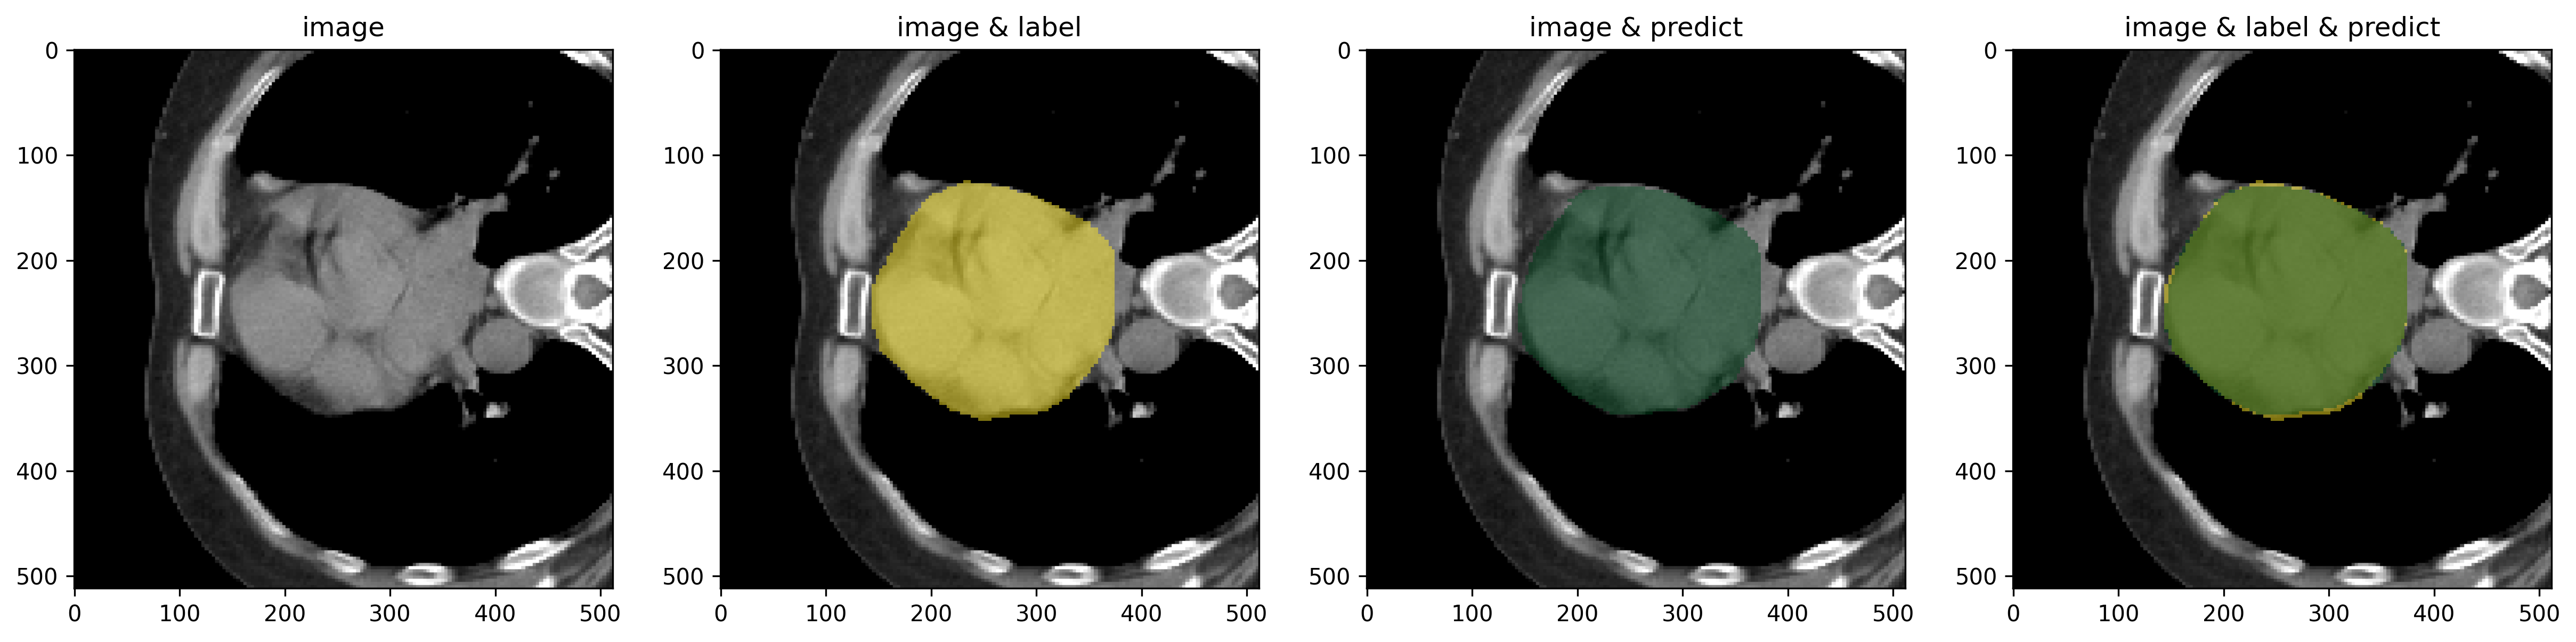

In [ ]:
output_data = {}
if config.__name__ == 'SegTHORConfig':
    tmp_data = pre_transforms(data_dict)
    tmp_data['pred'] = data['image'][0]
    tmp_data = post_transforms(tmp_data)
    output_data['image'] = tmp_data['pred']
    output_data['image_meta_dict'] = tmp_data['pred_meta_dict']

    tmp_data2 = pre_transforms(data_dict)
    tmp_data2['pred'] = data['label'][0]
    tmp_data2 = post_transforms(tmp_data2)
    output_data['label'] = tmp_data2['pred']
    output_data['label_meta_dict'] = tmp_data2['pred_meta_dict']

    output_data['pred'] = data['pred']
    output_data['pred_meta_dict'] = data['pred_meta_dict']

    show_img(output_data['image'][:,:,120], output_data['pred'][:,:,120], output_data['label'][:,:,120])

else:
    img = LoadImaged(keys=["image"])(data_dict)['image']
    output_data['pred'] = data['pred']
    output_data['pred_meta_dict'] = data['pred_meta_dict']
    
    show_img(img[:,:,80], output_data['pred'][:,:,80])

In [ ]:
def save_img(img, img_meta_dict, pth):
    writer = NibabelWriter()
    writer.set_data_array(AddChannel()(img))
    writer.set_metadata(img_meta_dict)
    writer.write(pth, verbose=True)

In [ ]:
if config.__name__ == 'SegTHORConfig':
    save_img(output_data['image'], output_data['image_meta_dict'], config.transform_img_pth)
    save_img(output_data['label'], output_data['label_meta_dict'], config.transform_lbl_pth)
    save_img(output_data['pred'], output_data['pred_meta_dict'], config.infer_img_pth)
else:
    save_img(output_data['pred'], output_data['pred_meta_dict'], config.infer_img_pth)

2022-07-20 08:09:11,224 INFO image_writer.py:192 - writing: ./UNETCNX_SegTHOR/infers/k7_f48_p4_d9/SegTHOR/Patient_40/trans_Patient_40.nii.gz
2022-07-20 08:09:14,008 INFO image_writer.py:192 - writing: ./UNETCNX_SegTHOR/infers/k7_f48_p4_d9/SegTHOR/Patient_40/trans_GT.nii.gz
2022-07-20 08:09:16,002 INFO image_writer.py:192 - writing: ./UNETCNX_SegTHOR/infers/k7_f48_p4_d9/SegTHOR/Patient_40/infer_Patient_40.nii.gz
